In [1]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import random
import shutil
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from google.colab import files
uploaded = files.upload()  # choose kaggle.json
# Move kaggle.json to ~/.kaggle
if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json', 'wb') as f:
        f.write(uploaded['kaggle.json'])
    !chmod 600 /root/.kaggle/kaggle.json
    print("kaggle.json uploaded and permission set.")
else:
    print("Please upload kaggle.json (from your Kaggle account).")


Saving kaggle.json to kaggle.json
kaggle.json uploaded and permission set.


In [3]:
# Download dataset from Kaggle
# Dataset: mbsoroush/rice-images-dataset
!kaggle datasets download -d mbsoroush/rice-images-dataset -p /content/rice_data --unzip


Dataset URL: https://www.kaggle.com/datasets/mbsoroush/rice-images-dataset
License(s): other
100% 220M/220M [00:00<00:00, 667MB/s] 
100% 220M/220M [00:00<00:00, 711MB/s]


In [4]:
# Adjust if dataset filename differs; this should create a folder with images.
!ls -la /content/rice_data

total 6844
drwxr-xr-x 7 root root    4096 Sep 26 08:08 .
drwxr-xr-x 1 root root    4096 Sep 26 08:08 ..
drwxr-xr-x 2 root root  589824 Sep 26 08:08 Arborio
drwxr-xr-x 2 root root  573440 Sep 26 08:08 Basmati
drwxr-xr-x 2 root root  561152 Sep 26 08:08 Ipsala
drwxr-xr-x 2 root root  610304 Sep 26 08:08 Jasmine
drwxr-xr-x 2 root root  589824 Sep 26 08:08 Karacadag
-rw-r--r-- 1 root root    3053 Sep 26 08:08 Rice_Citation_Request.txt
-rw-r--r-- 1 root root 4070313 Sep 26 08:08 S0168169921003021.pdf


In [5]:
# Inspect dataset folders (EDA)
import os
from glob import glob
dataset_dir = "/content/rice_data"
# Show class folders and counts
class_dirs = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
print("Detected classes:", class_dirs)
total_images = 0
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name}: {num_images} images")
        total_images += num_images
print("\nTotal images in dataset:", total_images)

Detected classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
Arborio: 15000 images
Basmati: 15000 images
Jasmine: 15000 images
Karacadag: 15000 images
Ipsala: 15000 images

Total images in dataset: 75000


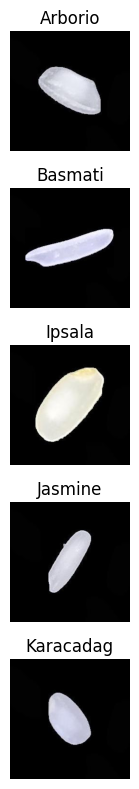

In [6]:
#  Visual EDA - display a few images from each class
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(14,8))
ncols = 5
nrows = len(class_dirs)
for i, c in enumerate(class_dirs):
    imgs = glob(os.path.join(dataset_dir, c, '*'))
    sample = random.choice(imgs)
    ax = plt.subplot(nrows, ncols, i*ncols + 1)
    img = mpimg.imread(sample)
    plt.imshow(img)
    plt.axis('off')
    plt.title(c)
plt.tight_layout()


In [7]:
# train/val/test split
import shutil
from pathlib import Path
import random

random.seed(42)
dataset_dir = Path(dataset_dir)
base = Path('/content/rice_dataset_split')
if base.exists():
    shutil.rmtree(base)
(base / 'train').mkdir(parents=True)
(base / 'val').mkdir(parents=True)
(base / 'test').mkdir(parents=True)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for c in class_dirs:
    imgs = list((dataset_dir / c).glob('*'))
    random.shuffle(imgs)
    n = len(imgs)
    ntrain = int(train_ratio * n)
    nval = int(val_ratio * n)
    train_imgs = imgs[:ntrain]
    val_imgs = imgs[ntrain:ntrain+nval]
    test_imgs = imgs[ntrain+nval:]
    for p in train_imgs:
        dest = base / 'train' / c
        dest.mkdir(parents=True, exist_ok=True)
        shutil.copy(p, dest / p.name)
    for p in val_imgs:
        dest = base / 'val' / c
        dest.mkdir(parents=True, exist_ok=True)
        shutil.copy(p, dest / p.name)
    for p in test_imgs:
        dest = base / 'test' / c
        dest.mkdir(parents=True, exist_ok=True)
        shutil.copy(p, dest / p.name)

print("Created split folders at", base)

Created split folders at /content/rice_dataset_split


In [8]:
#Prefetch and simple augmentation for CNN

from tensorflow.keras import layers

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
# Recreate datasets with new image size
print("training size")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base / 'train',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)
print("Validation Size")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base / 'val',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)
print("Testing Size")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base / 'test',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1,0.1)
])


# Normalize images to [0,1]
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y),
                        num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y),
                    num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y),
                     num_parallel_calls=AUTOTUNE)


training size
Found 60000 files belonging to 5 classes.
Validation Size
Found 7500 files belonging to 5 classes.
Testing Size
Found 7500 files belonging to 5 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(class_dirs), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 827,237 (3.16 MB)

 Trainable params: 827,013 (3.15 MB)

 Non-trainable params: 224 (896.00 B)

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_dirs), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
#Train  CNN model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "/content/best_rice_cnn.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8295 - loss: 0.4774

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 313s 158ms/step - accuracy: 0.8296 - loss: 0.4771 - val_accuracy: 0.9501 - val_loss: 0.1436 - learning_rate: 1.0000e-04
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9681 - loss: 0.1021

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 292s 149ms/step - accuracy: 0.9681 - loss: 0.1021 - val_accuracy: 0.9509 - val_loss: 0.1344 - learning_rate: 1.0000e-04
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9724 - loss: 0.0833

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 274s 146ms/step - accuracy: 0.9724 - loss: 0.0833 - val_accuracy: 0.9568 - val_loss: 0.1281 - learning_rate: 1.0000e-04
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 276s 147ms/step - accuracy: 0.9771 - loss: 0.0714 - val_accuracy: 0.9525 - val_loss: 0.1408 - learning_rate: 1.0000e-04
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 323s 148ms/step - accuracy: 0.9796 - loss: 0.0624 - val_accuracy: 0.9532 - val_loss: 0.1344 - learning_rate: 1.0000e-04
Epoch 6/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9815 - loss: 0.0569

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 275s 146ms/step - accuracy: 0.9815 - loss: 0.0569 - val_accuracy: 0.9599 - val_loss: 0.1225 - learning_rate: 1.0000e-04
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 277s 148ms/step - accuracy: 0.9824 - loss: 0.0543 - val_accuracy: 0.9503 - val_loss: 0.1475 - learning_rate: 1.0000e-04
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 322s 148ms/step - accuracy: 0.9825 - loss: 0.0543 - val_accuracy: 0.9595 - val_loss: 0.1245 - learning_rate: 1.0000e-04
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 319s 146ms/step - accuracy: 0.9829 - loss: 0.0533 - val_accuracy: 0.9545 - val_loss: 0.1386 - learning_rate: 1.0000e-04
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 274s 146ms/step - accuracy: 0.9842 - loss: 0.0496 - val_accuracy: 0.9536 - val_loss: 0.1385 - learning_rate: 5.0000e-05
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 320s 145ms/step - accuracy: 0.9855 - loss: 0.0467 - val_accuracy: 0.9608 - val_loss: 0.1234 - learning_rate: 5.0000e-05


In [18]:

# ----------------------------
# Step 2: Fine-tune last layers
# ----------------------------
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path_ft = "/content/best_rice_model_finetuned.h5"
callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(checkpoint_path_ft, monitor='val_loss', save_best_only=True)
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_ft
)

Epoch 1/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9005 - loss: 0.3406

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 306s 151ms/step - accuracy: 0.9006 - loss: 0.3405 - val_accuracy: 0.9499 - val_loss: 0.1537 - learning_rate: 1.0000e-05
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 275s 146ms/step - accuracy: 0.9708 - loss: 0.0923 - val_accuracy: 0.9525 - val_loss: 0.1550 - learning_rate: 1.0000e-05
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 278s 148ms/step - accuracy: 0.9783 - loss: 0.0705 - val_accuracy: 0.9325 - val_loss: 0.2194 - learning_rate: 1.0000e-05
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 275s 147ms/step - accuracy: 0.9824 - loss: 0.0547 - val_accuracy: 0.9405 - val_loss: 0.2042 - learning_rate: 1.0000e-05
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 279s 149ms/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.9403 - val_loss: 0.1950 - learning_rate: 5.0000e-06
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9854 - loss: 0.0480

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 280s 149ms/step - accuracy: 0.9854 - loss: 0.0480 - val_accuracy: 0.9543 - val_loss: 0.1511 - learning_rate: 5.0000e-06
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 284s 152ms/step - accuracy: 0.9870 - loss: 0.0416 - val_accuracy: 0.9428 - val_loss: 0.1911 - learning_rate: 5.0000e-06
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 279s 149ms/step - accuracy: 0.9868 - loss: 0.0401 - val_accuracy: 0.9501 - val_loss: 0.1621 - learning_rate: 5.0000e-06
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 277s 148ms/step - accuracy: 0.9883 - loss: 0.0366 - val_accuracy: 0.9489 - val_loss: 0.1708 - learning_rate: 5.0000e-06
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 277s 148ms/step - accuracy: 0.9896 - loss: 0.0331 - val_accuracy: 0.9499 - val_loss: 0.1638 - learning_rate: 2.5000e-06


In [19]:
# Evaluate CNN model
#loss, acc = model.evaluate(test_ds)
#print(f"Test loss: {loss:.4f}   Test accuracy: {acc:.4f}")
# Evaluate on test set
test_loss, test_acc= model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9692 - loss: 0.0977
Test loss: 0.1527 | Test accuracy: 0.9507


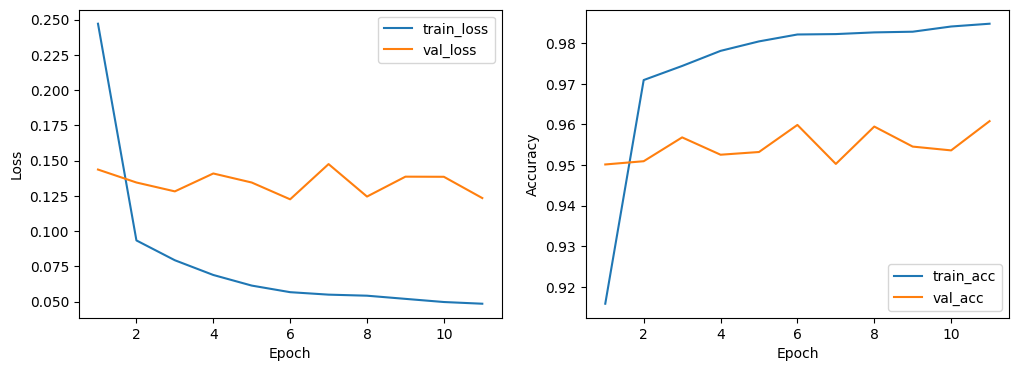

In [20]:
#Ploting training curves
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history.history['loss'])+1)
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['loss'], label='train_loss')
    plt.plot(epochs, history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['accuracy'], label='train_acc')
    plt.plot(epochs, history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.show()

plot_history(history)


In [21]:
# ---- Next Cell ----
# Save the final model
final_model_path = "/content/rice_model_final.h5"
model.save(final_model_path)
print("Saved final model to:", final_model_path)


Saved final model to: /content/rice_model_final.h5


In [27]:
# Confusion matrix & classification report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
print("Classification Report")
print(classification_report(y_true, y_pred, target_names=class_dirs))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


Classification Report
              precision    recall  f1-score   support

     Arborio       0.91      0.98      0.95      1500
     Basmati       0.99      0.95      0.97      1500
      Ipsala       0.90      1.00      0.95      1500
     Jasmine       0.96      0.91      0.93      1500
   Karacadag       1.00      0.91      0.95      1500

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500

Confusion matrix:
 [[1473    0   26    1    0]
 [   0 1430    8   62    0]
 [   0    0 1500    0    0]
 [  49    8   84 1358    1]
 [  91    0   40    0 1369]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


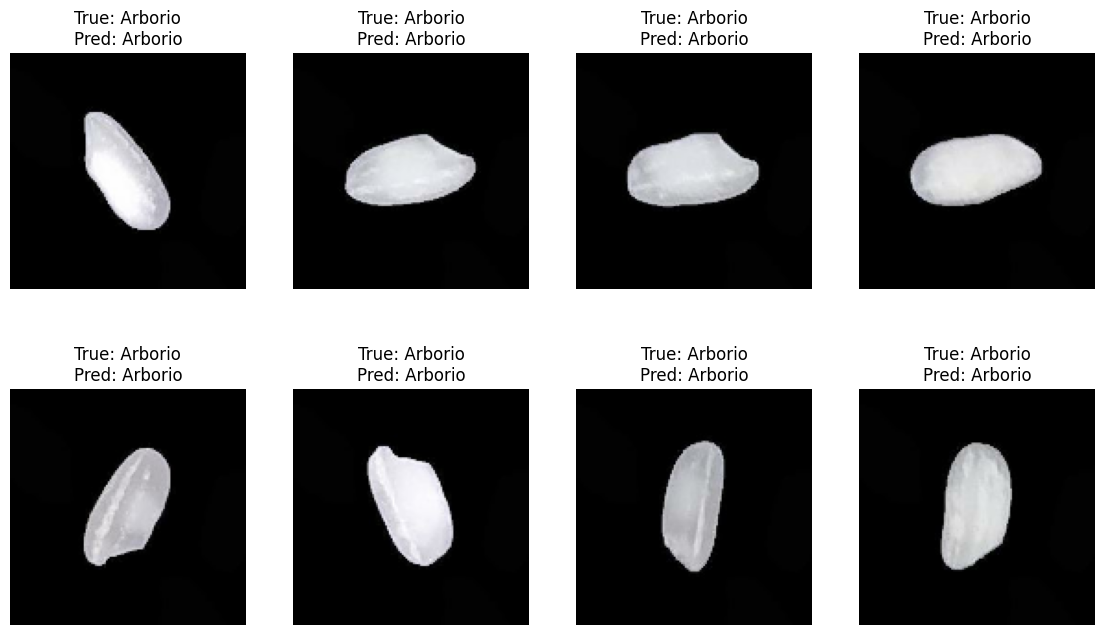

In [25]:
# ---- Next Cell ----
# Example: run predictions on a few test images and show results
import numpy as np
import matplotlib.pyplot as plt

# Get a batch from test_ds
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    plt.figure(figsize=(14,8))
    for i in range(min(8, images.shape[0])):
        ax = plt.subplot(2, 4, i+1)
        img = images[i].numpy()
        plt.imshow(img)
        plt.axis('off')
        ax.set_title(f"True: {class_dirs[true_classes[i]]}\nPred: {class_dirs[pred_classes[i]]}")
    plt.show()
    break

In [26]:
# ---- Next Cell ----
# If you want to export labels mapping for inference later
import json
class_map = {i: c for i, c in enumerate(class_dirs)}
with open('/content/class_map.json', 'w') as f:
    json.dump(class_map, f)
print("Saved class map to /content/class_map.json")

Saved class map to /content/class_map.json
